# Homework 1 Data Preparation and Exploratory Data Analysis

## 2021-0407 CIS 600 Fundamental Data & Knowledge Mining

### Tanay Nagireddy

#### This analysis/report focuses on preparing data for potential use in a model

"Analyze employee_attrition.csv dataset provided. This dataset provides a variety of information about
the employees, such as demographics, time on job, etc. and also if they stay with or leave the company
(as in binary attribute “Attrition” with No means stay and Yes means leaving)."

The target class labels are 'Yes' and 'No' for the target class/variable 'Attrition'.

 * Data Understanding
 * Data preprocessing, cleaning, and preparation
 * EDA (exploratory data analysis/modeling)
 * Presentation and visualization
 
 Steps involved:
 
 1. Display dataset and it's relevant information (shape, head, tail, info, describe, datatypes, etc.)
 2. Identify potential data quality issues - outliers
 3. Identify potential data quality issues - null values (missing data)
 4. Identify potential data quality issues - duplicates
 5. Data Visualization (boxplots and histograms)
 6. Correlation analysis
     * Feature scaling (standardization, normalization) (not actually required)
     * Statistical tests
     * Visualizations

## Libraries and Data

In [1]:
# import required libraries

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_letters

from collections import Counter, OrderedDict, namedtuple
import itertools 

import math
from scipy.stats import normaltest, shapiro
import scipy.stats as ss

from sklearn.preprocessing import MinMaxScaler

# plots visualizations below cell
%matplotlib inline

In [2]:
# storing employee attrition information

employee_info = pd.read_csv("employee_attrition.csv")

## Functions

The following functions provide a clean way to compute/conduct necessary data analysis, please see the function headers for information about each function. 

In [3]:
def splitByType(df):
    """
    Description: computes two dataframes based on the type of the columns (int64, float64, object)
    Input: dataframe containing cleansed data
    Return: dataframe containing only object type columns, and dataframe excluding only object type columns 
    """
    non_object_type = df.select_dtypes(exclude=['object'])  # int64, float64, etc.
    object_type = df.select_dtypes(include=['object'])  # string, etc.
    return {'non_object_type':non_object_type, 'object_type':object_type}

In [4]:
def displayBoxPlots(df):
    """
    Description: plots the boxplots of features/attributes/columns
    Input: non_object_type dataframe (int64, float64, etc.) containing cleansed data
    Return: plot of box plots
    Reference: https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
    """
    l = df.columns.values
    number_of_columns=7
    number_of_rows = len(l)-1/number_of_columns
    plt.figure(figsize=(number_of_columns,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.set_style('whitegrid')
        sns.boxplot(y=df[l[i]],color='green',orient='v')
        plt.tight_layout()

In [5]:
def displayDistribution(df):
    """
    Description: plots the distribution plots/histograms of features/attributes/columns
    Input: non_object_type dataframe (int64, float64, etc.) containing cleansed data
    Return: plot of distribution plots/histograms
    Reference: https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
    """
    l = df.columns.values
    number_of_columns=7
    number_of_rows = len(l)-1/number_of_columns
    plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
    for i in range(0,len(l)):
        plt.subplot(number_of_rows + 1,number_of_columns,i+1)
        sns.distplot(df[l[i]],kde=True)

In [6]:
def cramers_corrected_stat(confusion_matrix):
    """
    Description: calculate Cramers V statistic for categorical-categorical association
                 uses correction from Bergsma and Wicher 
    Input: confusion matrix of data
    Return: Cramer's V Statistic
    Reference: https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
               Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [7]:
def displayCramersV(df, columns_):
    """
    Description: displays Cramers V statistic for categorical-categorical association
    Input: object_type dataframe (int64, float64, etc.) containing cleansed data
           columns for that object_type dataframe
    Return: heatmap of Cramer's V Statistic for all combinations of columns in the passed dataframe
    Reference: https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features
    """
    cols = list(columns_)
    corrM = np.zeros((len(cols),len(cols)))

    for col1, col2 in itertools.combinations(cols, 2):
        idx1, idx2 = cols.index(col1), cols.index(col2)
        corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
        corrM[idx2, idx1] = corrM[idx1, idx2]
        
    corr = pd.DataFrame(corrM, index=cols, columns=cols)
    
    mask = np.triu(np.ones_like(corr, dtype=np.bool))

    mask = mask[1:, :-1]
    corr = corr.iloc[1:,:-1].copy()
    
    fig, ax = plt.subplots(figsize=(7, 6))
    ax = sns.heatmap(corr, mask=mask, annot=True, ax=ax)
    ax.set_title("Cramer's V Statistic for Correlation b/w Categorical Features")

In [8]:
def displayCorrelationHeatMap(df_corr):
    """
    Description: display a correlation matrix for the dataframe of correlation values (depending on the statistic)
    Input: dataframe of correlation values
    Result: heatmap of correlation matrix
    Reference: https://towardsdatascience.com/heatmap-basics-with-pythons-seaborn-fb92ea280a6c
    """
    plt.figure(figsize=(20,12))

    mask = np.triu(np.ones_like(df_corr, dtype=np.bool))

    mask = mask[1:, :-1]
    corr = df_corr.iloc[1:,:-1].copy()

    sns.heatmap(corr, mask=mask, cmap='viridis', annot=True)

In [9]:
def computeNormalityTests(df):
    """
    Description: Runs two statistical methods that test for a Gaussian-like distribution 
    Input: dataframe containig cleansed non-categorical data
    Return: prints the results of the tests based on hypothesis testing
    Reference: https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
    """
    for col in df.columns:

        # shapiro-wilk
        stat, p = shapiro(df[col])
        stats = 'Statistics=%.3f, p=%.3f' % (stat, p)

        # interpret shapiro-wilk
        alpha = 0.05 
        if p > alpha:    
            print('{} : Shapiro-Wilk : {} \n ~~~~ Sample looks Gaussian (fail to reject H0)'.format(col, stats))
        else:
            print('{} : Shapiro-Wilk : {} \n ---- Sample does not look Gaussian (reject H0)'.format(col, stats))

        # d'agostino
        stat, p = normaltest(df[col])
        stats = 'Statistics=%.3f, p=%.3f' % (stat, p)

        # interpret d'agostino
        alpha = 0.05
        if p > alpha:
            print('{} : D’Agostino : {} \n ~~~~ Sample looks Gaussian (fail to reject H0)'.format(col, stats))
        else:
            print('{} : D’Agostino : {} \n ---- Sample does not look Gaussian (reject H0)'.format(col, stats))

In [10]:
"""
Description: the following function calculate the theils U metric for categorical-categorical association
Input: dataframe with cleansed categorical data
Return: heatmap of target class/variable theil's U metric against the other categorical features/attributes/predictors
Reference: This code is taken from shakedzy on the Kaggle platform
           https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival
"""

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x
    
def computeTheilU(data):

    theilu = pd.DataFrame(index=['Attrition'],columns=data.columns)
    columns = data.columns
    for j in range(0,len(columns)):
        u = theil_u(data['Attrition'].tolist(),data[columns[j]].tolist())
        theilu.loc[:,columns[j]] = u
    theilu.fillna(value=np.nan,inplace=True)
    plt.figure(figsize=(20,1))
    sns.heatmap(theilu,annot=True,fmt='.2f')
    plt.show()

In [11]:
def correlation_ratio(categories, measurements):
    """
    Description: this function calculates the correlation ratio between a given categorical feature/variable and 
                 a non-categorical feature/variable
    Input: dataframe column with cleansed categorical data, and dataframe column with cleansed non-categorical data
    Return: eta or the correlation ratio between these two features/attributes/predictors
    Reference: this code is taken from Shaked Zychlinski
               https://stackoverflow.com/questions/52083501/how-to-compute-correlation-ratio-or-eta-in-python
               https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
    """
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

In [12]:
def checkMonotonicity(df):
    """
    Description: check monotonicity of an individual feature/attribute/predictor
    Input: dataframe with cleansed non-object type data
    Return: prints whether data is increasing or decreasing
    """
    for col in df.columns:
        print("{} : is_increasing = {} : is_decreasing = {}".format(
            col,
            pd.Series(list(df[col])).is_monotonic_increasing, 
            pd.Series(list(df[col])).is_monotonic_decreasing
        ))

In [13]:
import warnings
warnings.simplefilter('ignore')

## Displaying employee information and summary statistics

To start off the analysis, we're going to look at some high-level summary information of our employee attrition dataset.

 * displaying the dimensions of the dataframe

In [14]:
employee_info.shape

(1176, 35)

There are 35 attributes including the target class/variable, let's check out the data type distribution of these attributes.

 * displaying the datatype for each column in the dataset

In [15]:
print("number of attributes: \n non_object_type: {} \n object_type: {}".format(len(splitByType(employee_info)['non_object_type'].columns), len(splitByType(employee_info)['object_type'].columns)))

number of attributes: 
 non_object_type: 26 
 object_type: 9


Taking a look at which attributes/features/predictors are present in each of the categories:

In [16]:
splitByType(employee_info)['non_object_type'].columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [17]:
splitByType(employee_info)['object_type'].columns

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

and the counts of the same dataset on a more granular level where 'O' stands for object type with non_object_type being split into int and float types: 

In [18]:
Counter(employee_info.dtypes)

Counter({dtype('int64'): 19, dtype('O'): 9, dtype('float64'): 7})

 * displaying the first 5 rows of the dataframe

In [19]:
employee_info.head()

Age Attrition BusinessTravel  DailyRate              Department  \
0   30        No  Travel_Rarely       1358                   Sales   
1   52        No  Travel_Rarely       1325  Research & Development   
2   42        No  Travel_Rarely        462                   Sales   
3   55        No     Non-Travel        177  Research & Development   
4   35        No  Travel_Rarely       1029  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0              16.0          1  Life Sciences              1            1479   
1              11.0          4  Life Sciences              1             813   
2              14.0          2        Medical              1             936   
3               8.0          1        Medical              1            1278   
4              16.0          3  Life Sciences              1            1529   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  JobLevel  \
0                        4    Male          96               3       2.0   
1                        4  Female          82               3       2.0   
2                        3  Female          68               2       2.0   
3                        4    Male          37               2       4.0   
4                        4  Female          91               2       3.0   

                     JobRole  JobSatisfaction MaritalStatus  MonthlyIncome  \
0            Sales Executive                3       Married           5301   
1      Laboratory Technician                3       Married           3149   
2            Sales Executive                3        Single           6244   
3  Healthcare Representative                2      Divorced          13577   
4  Healthcare Representative                2        Single           8606   

   MonthlyRate  NumCompaniesWorked Over18 OverTime  PercentSalaryHike  \
0         2939                   8      Y       No               15.0   
1        21821                   8      Y       No               20.0   
2         7824                   7      Y       No               17.0   
3        25592                   1      Y      Yes               15.0   
4        21195                   1      Y       No               19.0   

   PerformanceRating  RelationshipSatisfaction  StandardHours  \
0                3.0                       3.0             80   
1                4.0                       2.0             80   
2                3.0                       1.0             80   
3                3.0                       4.0             80   
4                3.0                       4.0             80   

   StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  \
0                 2                4.0                      2   
1                 1                9.0                      3   
2                 0               10.0                      6   
3                 1               34.0                      3   
4                 0               11.0                      3   

   WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
0                2               2                   1   
1                3               5                   2   
2                3               5                   4   
3                3              33                   9   
4                1              11                   8   

   YearsSinceLastPromotion  YearsWithCurrManager  
0                      2.0                     2  
1                      1.0                     4  
2                      0.0                     3  
3                     15.0                     0  
4                      3.0                     3

 * displaying the last 5 rows of the dataframe

In [20]:
employee_info.tail()

Age Attrition BusinessTravel  DailyRate              Department  \
1171   28        No  Travel_Rarely       1169         Human Resources   
1172   36        No  Travel_Rarely        430  Research & Development   
1173   51        No  Travel_Rarely        432  Research & Development   
1174   38        No  Travel_Rarely        437                   Sales   
1175   50        No  Travel_Rarely       1322  Research & Development   

      DistanceFromHome  Education EducationField  EmployeeCount  \
1171               8.0          2        Medical              1   
1172               2.0          4          Other              1   
1173               9.0          4  Life Sciences              1   
1174              16.0          3  Life Sciences              1   
1175              28.0          3  Life Sciences              1   

      EmployeeNumber  EnvironmentSatisfaction  Gender  HourlyRate  \
1171             869                        2    Male          63   
1172            1847                        4  Female          73   
1173             116                        4    Male          96   
1174            1583                        2  Female          90   
1175            1317                        4  Female          43   

      JobInvolvement  JobLevel                JobRole  JobSatisfaction  \
1171               2       1.0        Human Resources                4   
1172               3       2.0     Research Scientist                2   
1173               3       1.0  Laboratory Technician                4   
1174               3       2.0        Sales Executive                2   
1175               3       4.0      Research Director                1   

     MaritalStatus  MonthlyIncome  MonthlyRate  NumCompaniesWorked Over18  \
1171      Divorced           4936        23965                   1      Y   
1172       Married           6962        19573                   4      Y   
1173       Married           2075        18725                   3      Y   
1174        Single           4198        16379                   2      Y   
1175       Married          16880        22422                   4      Y   

     OverTime  PercentSalaryHike  PerformanceRating  RelationshipSatisfaction  \
1171       No               13.0                3.0                       4.0   
1172      Yes               22.0                4.0                       4.0   
1173       No               23.0                4.0                       2.0   
1174       No               12.0                3.0                       2.0   
1175      Yes               11.0                3.0                       2.0   

      StandardHours  StockOptionLevel  TotalWorkingYears  \
1171             80                 1                6.0   
1172             80                 1               15.0   
1173             80                 2               10.0   
1174             80                 0                8.0   
1175             80                 0               25.0   

      TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  \
1171                      6                3               5   
1172                      2                3               1   
1173                      4                3               4   
1174                      5                4               3   
1175                      2                3               3   

      YearsInCurrentRole  YearsSinceLastPromotion  YearsWithCurrManager  
1171                   1                      0.0                     4  
1172                   0                      0.0                     0  
1173                   2                      0.0                     3  
1174                   2                      1.0                     2  
1175                   2                      1.0                     2

 * displaying a summary of information for the dataset

In [21]:
employee_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176 entries, 0 to 1175
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1176 non-null   int64  
 1   Attrition                 1176 non-null   object 
 2   BusinessTravel            1176 non-null   object 
 3   DailyRate                 1176 non-null   int64  
 4   Department                1176 non-null   object 
 5   DistanceFromHome          1174 non-null   float64
 6   Education                 1176 non-null   int64  
 7   EducationField            1176 non-null   object 
 8   EmployeeCount             1176 non-null   int64  
 9   EmployeeNumber            1176 non-null   int64  
 10  EnvironmentSatisfaction   1176 non-null   int64  
 11  Gender                    1175 non-null   object 
 12  HourlyRate                1176 non-null   int64  
 13  JobInvolvement            1176 non-null   int64  
 14  JobLevel

Immediately, we can see that there are some values missing, will definitely have to deal with this later.

 * displaying basic summary statistics for feasible features in the dataset

In [22]:
employee_info.describe()

Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1176.000000  1176.000000       1174.000000  1176.000000         1176.0   
mean     36.960034   800.386905          9.495741     2.895408            1.0   
std       9.071964   404.709216         10.251379     1.025685            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   461.750000          2.000000     2.000000            1.0   
50%      36.000000   796.000000          7.000000     3.000000            1.0   
75%      43.000000  1162.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000        224.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1176.000000              1176.000000  1176.000000     1176.000000   
mean      1036.430272                 2.704932    65.822279        2.740646   
std        600.681874                 1.094128    20.292035        0.719277   
min          1.000000                 1.000000    30.000000        1.000000   
25%        499.750000                 2.000000    48.000000        2.000000   
50%       1032.500000                 3.000000    66.000000        3.000000   
75%       1574.500000                 4.000000    83.000000        3.000000   
max       2068.000000                 4.000000   100.000000        4.000000   

          JobLevel  JobSatisfaction  MonthlyIncome   MonthlyRate  \
count  1175.000000      1176.000000    1176.000000   1176.000000   
mean      2.068936         2.710034    6525.534014  14467.688776   
std       1.109590         1.113217    4707.507472   7107.658362   
min       1.000000         1.000000    1009.000000   2094.000000   
25%       1.000000         2.000000    2954.500000   8275.000000   
50%       2.000000         3.000000    4950.500000  14488.000000   
75%       3.000000         4.000000    8354.500000  20627.250000   
max       5.000000         4.000000   19973.000000  26999.000000   

       NumCompaniesWorked  PercentSalaryHike  PerformanceRating  \
count         1176.000000        1175.000000        1175.000000   
mean             2.709184          15.295319           3.162553   
std              2.476191           3.698902           0.369115   
min              0.000000          11.000000           3.000000   
25%              1.000000          12.000000           3.000000   
50%              2.000000          14.000000           3.000000   
75%              4.000000          18.000000           3.000000   
max              9.000000          25.000000           4.000000   

       RelationshipSatisfaction  StandardHours  StockOptionLevel  \
count               1175.000000         1176.0       1176.000000   
mean                   2.718298           80.0          0.795918   
std                    1.084095            0.0          0.847033   
min                    1.000000           80.0          0.000000   
25%                    2.000000           80.0          0.000000   
50%                    3.000000           80.0          1.000000   
75%                    4.000000           80.0          1.000000   
max                    4.000000           80.0          3.000000   

       TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  \
count        1174.000000            1176.000000      1176.000000   
mean           11.402896               2.809524         2.747449   
std             8.368864               1.307697         0.691586   
min             0.000000               0.000000         1.000000   
25%             6.000000               2.000000         2.000000   
50%            10.000000               3.000000         3.000000   
75%            15.000000               3.000000         3.000000   
max           114.000000               6.000000         4.000000   

       YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
count     1176.000000         1176.000000              1175.

Apart from provide the quantiles and other basic statistical information, the describe() method can also inform us of any skewness in the distribution depending on whether the mode > mean (left-skew/negative skew) or  mode < mean (right-skew/positive skew), we will also use histrograms to visualize this.

## Dealing with Data Issues
 * display boxplots to identify outliers (any extreme values)

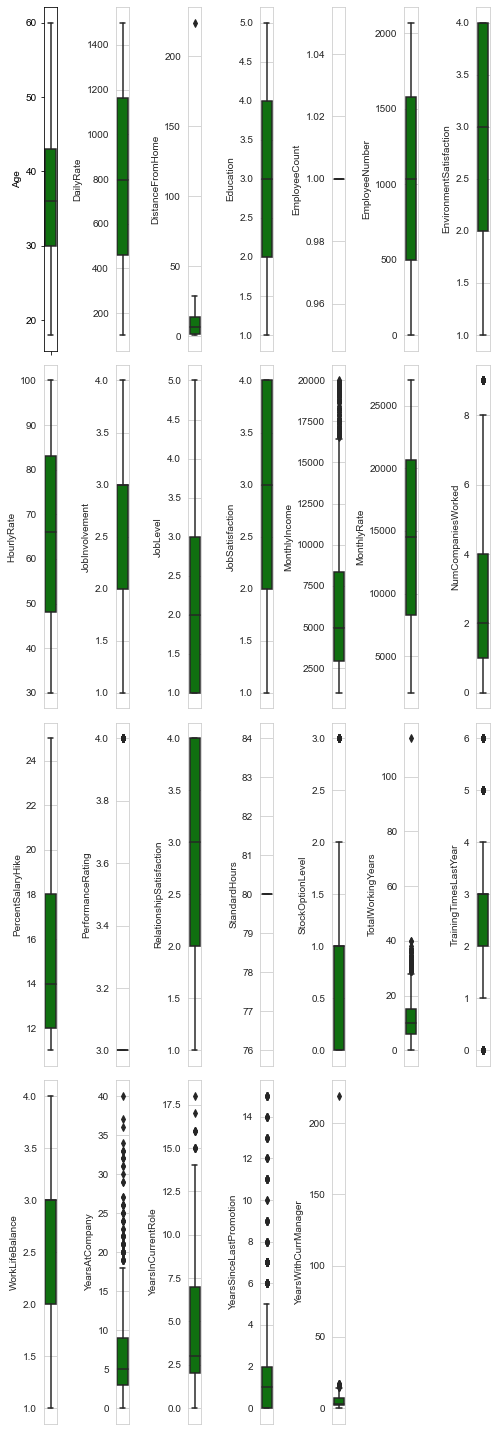

In [23]:
displayBoxPlots(splitByType(employee_info)['non_object_type'])

Yikes, some of the features have some really odd outliers:
 - DistanceFromHome (over 200? maybe remote)
 - TotalWorkingYears (over 100! I think they mean 10? possible typo)
 - YearsWithCurrManager (over 200! No one has ever lived this long, I think they mean 10? possible typo)
 
These values will be removed as they are unreasonable for their respective attributes

In [24]:
employee_info[employee_info['DistanceFromHome'] > 200].index

Int64Index([126], dtype='int64')

In [25]:
employee_info[employee_info['TotalWorkingYears'] > 100].index

Int64Index([143], dtype='int64')

In [26]:
employee_info[employee_info['YearsWithCurrManager'] > 200].index

Int64Index([1054], dtype='int64')

In [27]:
employee_info.loc[126,'DistanceFromHome'] = np.nan

In [28]:
employee_info.loc[143,'TotalWorkingYears'] = np.nan

In [29]:
employee_info.loc[1054,'YearsWithCurrManager'] = np.nan

Now we will see how many empty values we have in our dataset:

In [30]:
print("Total number of records containing null values: {}".format(len(employee_info[employee_info.isnull().any(axis=1) == True])))

Total number of records containing null values: 14


Let's go through these records in detail:

In [31]:
employee_info[employee_info.isnull().any(axis=1) == True]

Age Attrition     BusinessTravel  DailyRate              Department  \
9      27       Yes      Travel_Rarely       1420                   Sales   
32     38        No         Non-Travel        573  Research & Development   
54     39        No      Travel_Rarely        412  Research & Development   
63     43        No      Travel_Rarely        930  Research & Development   
82     38        No      Travel_Rarely        362  Research & Development   
88     28        No      Travel_Rarely       1476  Research & Development   
104    38        No      Travel_Rarely        688  Research & Development   
126    31        No      Travel_Rarely       1062  Research & Development   
143    36        No  Travel_Frequently        541                   Sales   
968    39       Yes  Travel_Frequently        203  Research & Development   
993    36        No         Non-Travel        301                   Sales   
1012   55        No      Travel_Rarely        692  Research & Development   
1054   42        No         Non-Travel        495  Research & Development   
1061   56        No  Travel_Frequently        906                   Sales   

      DistanceFromHome  Education EducationField  EmployeeCount  \
9                  2.0          1      Marketing              1   
32                 6.0          3        Medical              1   
54                 NaN          4        Medical              1   
63                 6.0          3        Medical              1   
82                 1.0          1  Life Sciences              1   
88                16.0          2        Medical              1   
104                NaN          4  Life Sciences              1   
126                NaN          3        Medical              1   
143                3.0          4        Medical              1   
968                2.0          3  Life Sciences              1   
993               15.0          4      Marketing              1   
1012              14.0          4        Medical              1   
1054               2.0          1  Life Sciences              1   
1061               6.0          3  Life Sciences              1   

      EmployeeNumber  EnvironmentSatisfaction  Gender  HourlyRate  \
9                667                        3    Male          85   
32               107                        2  Female          79   
54              1307                        3  Female          94   
63              1402                        1  Female          73   
82               662                        3  Female          43   
88               412                        2    Male          68   
104              393                        4    Male          82   
126             1252                        3  Female          96   
143              481                        1    Male          48   
968             1127                        1    Male          84   
993             2036                        4    Male          88   
1012             254                        3    Male          61   
1054            1334                        3    Male          37   
1061             532                        3     NaN          86   

      JobInvolvement  JobLevel                    JobRole  JobSatisfaction  \
9                  3       1.0       Sales Representative                1   
32                 1       2.0         Research Scientist                4   
54                 2       4.0                    Manager                2   
63                 2       2.0         Research Scientist                3   
82                 3       1.0         Research Scientist                1   
88                 4       NaN  Healthcare Representative                1   
104                3       2.0  Healthcare Representative                4   
126                2       2.0  Healthcare Representative                1   
143                2       3.0            Sales Executive                4   
968                3       4

We can see that there are some attributes like 'Gender' and 'OverTime' with empty values. 

In [32]:
splitByType(employee_info)['object_type'][splitByType(employee_info)['object_type'].isnull().any(axis=1) == True]

Attrition     BusinessTravel              Department EducationField  \
1012        No      Travel_Rarely  Research & Development        Medical   
1061        No  Travel_Frequently                   Sales  Life Sciences   

     Gender            JobRole MaritalStatus Over18 OverTime  
1012   Male  Research Director        Single      Y      NaN  
1061    NaN    Sales Executive       Married      Y       No

Since there are only two records, we can go ahead and just ignore these two records, and so we will remove them from the dataset.

In [33]:
employee_info.drop(list(splitByType(employee_info)['object_type'][splitByType(employee_info)['object_type'].isnull().any(axis=1) == True].index), inplace=True)

Let's check the dimensions real quick:

In [34]:
print(employee_info.shape, "-- the number of records went down by 2 from 1176 to 1174, great!")

(1174, 35) -- the number of records went down by 2 from 1176 to 1174, great!


Now we will deal with the non-object type attributes/columns:

In [35]:
splitByType(employee_info)['non_object_type'][splitByType(employee_info)['non_object_type'].isnull().any(axis=1) == True]

Age  DailyRate  DistanceFromHome  Education  EmployeeCount  \
9      27       1420               2.0          1              1   
32     38        573               6.0          3              1   
54     39        412               NaN          4              1   
63     43        930               6.0          3              1   
82     38        362               1.0          1              1   
88     28       1476              16.0          2              1   
104    38        688               NaN          4              1   
126    31       1062               NaN          3              1   
143    36        541               3.0          4              1   
968    39        203               2.0          3              1   
993    36        301              15.0          4              1   
1054   42        495               2.0          1              1   

      EmployeeNumber  EnvironmentSatisfaction  HourlyRate  JobInvolvement  \
9                667                        3          85               3   
32               107                        2          79               1   
54              1307                        3          94               2   
63              1402                        1          73               2   
82               662                        3          43               3   
88               412                        2          68               4   
104              393                        4          82               3   
126             1252                        3          96               2   
143              481                        1          48               2   
968             1127                        1          84               3   
993             2036                        4          88               1   
1054            1334                        3          37               3   

      JobLevel  JobSatisfaction  MonthlyIncome  MonthlyRate  \
9          1.0                1           3041        16346   
32         2.0                4           5329        15717   
54         4.0                2          17123        17334   
63         2.0                3           4081        20003   
82         1.0                1           2619        14561   
88         NaN                1           5661         4824   
104        2.0                4           5745        18899   
126        2.0                1           6812        17198   
143        3.0                4           9699         7246   
968        4.0                4          12169        13547   
993        2.0                4           5406        10436   
1054       4.0                3          17861        26582   

      NumCompaniesWorked  PercentSalaryHike  PerformanceRating  \
9                      0               11.0                NaN   
32                     7               12.0                3.0   
54                     6               13.0                3.0   
63                     1                NaN                3.0   
82                     3               17.0                3.0   
88                     0               19.0                3.0   
104                    9               14.0                3.0   
126                    1               19.0                3.0   
143                    4               11.0                3.0   
968                    7               11.0                3.0   
993                    1               24.0                4.0   
1054                   0               13.0                3.0   

      RelationshipSatisfaction  StandardHours  StockOptionLevel  \
9                          2.0             80                 1   
32                         NaN             80                 3   
54                         4.0             80                 2   
63                         1.0             80                 0   
82                         4.0             80                 0   
88                         3.0        

To prevent losing these records as there are quite a few, we will replace the null values with the mean of their respective attributes/features.

In [36]:
for col in splitByType(employee_info)['non_object_type'].columns:
    employee_info[col].fillna(np.rint(employee_info[col].mean()), inplace=True)

Now we'll check for any duplicates in the dataset:

In [37]:
print(Counter(employee_info.duplicated()), "-- since the total number of columns 1174, there are no duplicates, awesome!")

Counter({False: 1174}) -- since the total number of columns 1174, there are no duplicates, awesome!


Let's check also see the counts for attrition (target variable) values:

In [38]:
att_total = Counter(employee_info['Attrition'])['No']+Counter(employee_info['Attrition'])['Yes']
print(Counter(employee_info['Attrition']), "-- out of {}, about {}% No, and {}% Yes".format(
    att_total,
    np.rint((Counter(employee_info['Attrition'])['No']/att_total)*100),
    np.rint((Counter(employee_info['Attrition'])['Yes']/att_total)*100)
))

Counter({'No': 989, 'Yes': 185}) -- out of 1174, about 84.0% No, and 16.0% Yes


Not the best distribution of values, as we can see attrition is skewed with a very large majority of the values being 'No'.

Let's take a look at the the other categorical columns as well sorting the values in descending order:

In [39]:
for col in splitByType(employee_info)['object_type']:
    try:
        print("{} {}: {}\n\n".format(
            col, 
            len(employee_info[col].unique()), 
            sorted(dict(Counter(employee_info[col])).items(),  
                   key=lambda item: item[1], reverse=True)))
    except Exception as err:
        print(f"{col}: {err}\n\n")
        continue

Attrition 2: [('No', 989), ('Yes', 185)]


BusinessTravel 3: [('Travel_Rarely', 838), ('Travel_Frequently', 226), ('Non-Travel', 110)]


Department 3: [('Research & Development', 763), ('Sales', 357), ('Human Resources', 54)]


EducationField 6: [('Life Sciences', 476), ('Medical', 380), ('Marketing', 127), ('Technical Degree', 97), ('Other', 69), ('Human Resources', 25)]


Gender 2: [('Male', 692), ('Female', 482)]


JobRole 9: [('Sales Executive', 262), ('Research Scientist', 220), ('Laboratory Technician', 209), ('Manufacturing Director', 122), ('Healthcare Representative', 108), ('Manager', 79), ('Sales Representative', 67), ('Research Director', 64), ('Human Resources', 43)]


MaritalStatus 3: [('Married', 544), ('Single', 364), ('Divorced', 266)]


Over18 1: [('Y', 1174)]


OverTime 2: [('No', 837), ('Yes', 337)]




Interesting, there are some things to note:
 * immediately we can see that Over18 is redundant can be dropped (cardinality of 1)
 * OverTime shows a similar skewed distribution of values to attrition
 * majority of folks work in the Research & Development department
 * majority of folks also don't travel much (assuming that this is in the context of travelling for work)

## Data Visualization - BoxPlots

After all that data prep, let's display the finalized box plots for non-object type attributes/features/columns:

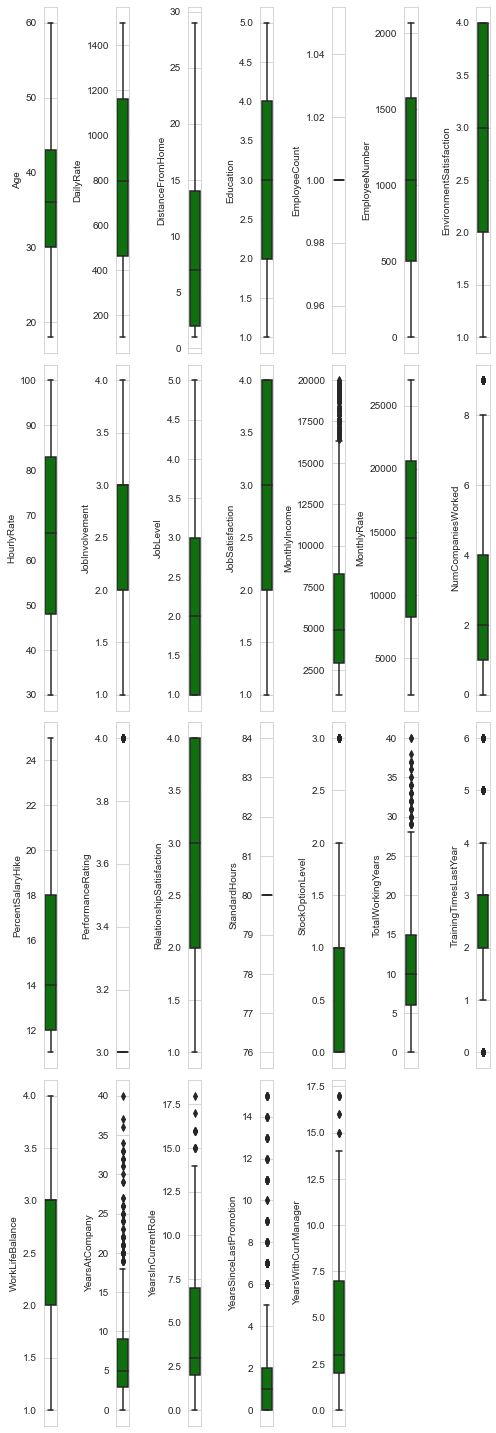

In [40]:
displayBoxPlots(splitByType(employee_info)['non_object_type'])

We can see that while outliers are still present, the extremely large values have been eradicated, and the percentiles are more visible with a better spread as compared to the previous run.

## Data Visualization - Histograms

Similarly, let's display the finalized frequencty distribution plots/histograms for non-object type attributes/features/columns:

In [41]:
employee_info.describe()

Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1174.000000  1174.000000       1174.000000  1174.000000         1174.0   
mean     36.928450   800.389267          9.310903     2.894378            1.0   
std       9.047285   405.029989          8.111936     1.026047            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   461.250000          2.000000     2.000000            1.0   
50%      36.000000   796.000000          7.000000     3.000000            1.0   
75%      43.000000  1162.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1174.000000              1174.000000  1174.000000     1174.000000   
mean      1037.526405                 2.704429    65.809199        2.738501   
std        600.577962                 1.094992    20.300287        0.718006   
min          1.000000                 1.000000    30.000000        1.000000   
25%        500.250000                 2.000000    48.000000        2.000000   
50%       1034.000000                 3.000000    66.000000        3.000000   
75%       1575.500000                 4.000000    83.000000        3.000000   
max       2068.000000                 4.000000   100.000000        4.000000   

          JobLevel  JobSatisfaction  MonthlyIncome   MonthlyRate  \
count  1174.000000      1174.000000    1174.000000   1174.000000   
mean      2.064736         2.712095    6509.449744  14465.423339   
std       1.105315         1.112851    4693.955948   7112.778471   
min       1.000000         1.000000    1009.000000   2094.000000   
25%       1.000000         2.000000    2951.500000   8271.000000   
50%       2.000000         3.000000    4941.000000  14488.000000   
75%       3.000000         4.000000    8307.750000  20643.750000   
max       5.000000         4.000000   19973.000000  26999.000000   

       NumCompaniesWorked  PercentSalaryHike  PerformanceRating  \
count         1174.000000        1174.000000        1174.000000   
mean             2.699319          15.302385           3.162692   
std              2.466633           3.696229           0.369241   
min              0.000000          11.000000           3.000000   
25%              1.000000          12.000000           3.000000   
50%              2.000000          14.000000           3.000000   
75%              4.000000          18.000000           3.000000   
max              9.000000          25.000000           4.000000   

       RelationshipSatisfaction  StandardHours  StockOptionLevel  \
count               1174.000000         1174.0       1174.000000   
mean                   2.716354           80.0          0.794719   
std                    1.083294            0.0          0.844988   
min                    1.000000           80.0          0.000000   
25%                    2.000000           80.0          0.000000   
50%                    3.000000           80.0          1.000000   
75%                    4.000000           80.0          1.000000   
max                    4.000000           80.0          3.000000   

       TotalWorkingYears  TrainingTimesLastYear  WorkLifeBalance  \
count        1174.000000            1174.000000      1174.000000   
mean           11.272572               2.811755         2.747871   
std             7.747000               1.306224         0.691792   
min             0.000000               0.000000         1.000000   
25%             6.000000               2.000000         2.000000   
50%            10.000000               3.000000         3.000000   
75%            15.000000               3.000000         3.000000   
max            40.000000               6.000000         4.000000   

       YearsAtCompany  YearsInCurrentRole  YearsSinceLastPromotion  \
count     1174.000000         1174.000000              1174.

As previously mentioned, let's visualize the skewness to get the overall picture rather than just looking at the values above:

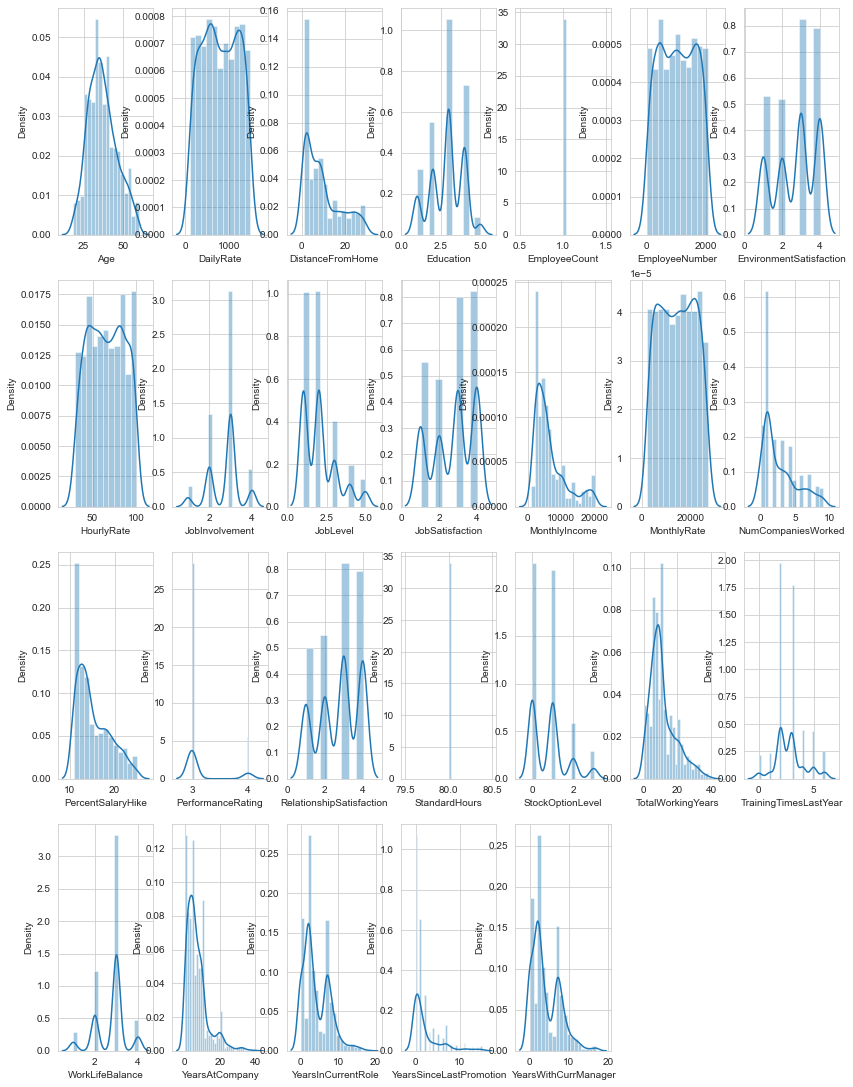

In [42]:
displayDistribution(splitByType(employee_info)['non_object_type'])

We can see that there are some attributes/features that can be dropped off the bat:
 * StandardHours (cardinality of 1 )
 * PerformanceRating (high cardinality - only 2 values, but is not binary categorical, would not help in predicting attrition)
 * EmployeeCount (cardinality of 1 )
 * EmployeeNumber (arbitrarily generated, not needed)

We can observe varying frequency distribution types:

*It appears that some of the plots are deceiving with gaps (as there are only a few possible integer values, ex. 1 through 4 for WorkLifeBalance) and multimodal depications are actually just skewed in a particular direction if they are not already normally distributed.*

 * normal distribution [Age, JobLevel, JobInvolvement, TrainingTimesLastYear, WorkLifeBalance]
     * even though it appears that these attributes may have a Gaussian-like distribution visually, it does not mean that they do indeed are distributed in a Guassian-like manner 
     * Shapiro-Wilk, D’Agostino’s K^2 Test, Anderson-Darling, QQ Plots are some of the other methods we can use to determine whether any of the data follows a Gaussian-like distribution
 * bi-modal distribution [Daily, Hourly, and Monthly rates]
 * right/positive skew [DistanceFromHome, MonthlyIncome, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager, TotalWorkingYears, PercentSalaryHike, StockOptionLevel]
 * left/negative skew [JobSatisfaction, RelationshipSatisfaction]
 
This information will be useful in determining the statistical test required.

We can also see that similar attributes have the same spread:
 * rates show the same distribution
 * job attributes show the same distribution
 * 'YearsAt...' show the same distribution

References:
- https://www.statisticshowto.com/probability-and-statistics/skewed-distribution/
- http://math.ucdenver.edu/~ssantori/MATH2830SP13/Math2830Chapter02Slides.pdf

## Correlation

Before we dive into the different methods utilized for finding the correlation between the target class/variable employee attrition and the other predictors/attributes/features, from the insights gathered previously, we know that we can drop some irrelevant columns:

In [43]:
employee_info = employee_info.drop(columns=['Over18', 'StandardHours', 'PerformanceRating', 'EmployeeCount', 'EmployeeNumber'])

### Categorical Data

For categorical-categorical relationships we will utilize the Cramer's V statistic to find any association between the target variable/class and the other features/attributes/predictors. We can avoid mapping these values to integer values as the integer values would add some order (increasing/decreasing), thereby altering the meaning the attribute.

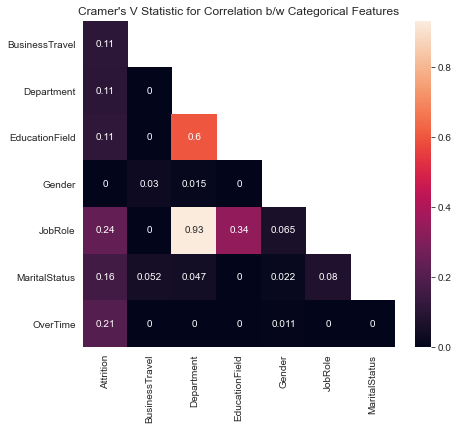

In [44]:
displayCramersV(splitByType(employee_info)['object_type'], splitByType(employee_info)['object_type'].columns)

From this we can see that:
 * it does not look like 'Gender' is insignificant and can be dropped
 * Department, JobRole, and EducationField are strongly correlated with each other
     * education-field - department (0.6)
     * education-field - jobrole (0.34)
     * department - jobrole (0.93)
 * the target class/variable attrition is moderately associated with JobRole (0.24) and OverTime (0.21)
 * the target class/variable attrition weakly associated/correlated with BusinessTravel, Department, EducationField, MaritalStatus (all at 0.11, except maritalstatus with 0.16)
 * depending on the classifier, higher correlated variables may need to be combined or dropped

As noted by Zychlinski (https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9) and others, Cramer's V is symmetric and the Uncertainty Coefficient is asymmetric (not symmetric), and therefore is sensitive to swapping x and y attributes that is lost in Cramer's V.

For example, (U = Theil's U), U(Attrition as x, and JobRole as y) != U(Attrition as y, and JobRole as x) whereas in Cramer's V, this is the opposite. 

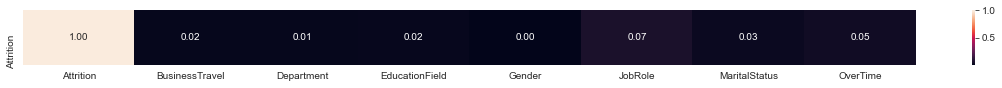

In [45]:
computeTheilU(splitByType(employee_info)['object_type'])

We can see that Theil's U (Uncertainty Coefficient) is no where near as optimistic as Cramer's V Statistic (extremely small Theil's U values) and this is expected, it may be useful to see how a model behaves in light of these constrasting findings.

### Non-Categorial Data

For the non-categorical attributes, binarization will be used on 'Attrition' to see if there is any correlation:

But before we carry out binarization, we can look at 'Attrition' directly using the correlation ratio. Before doing this, we're going to rescale/normalize the data for further processing (although it is not strictly required and is based on the ML model being implemented post-analysis).

In [46]:
scaler = MinMaxScaler() 
data_scaled = scaler.fit_transform(splitByType(employee_info)['non_object_type'])
dataset = pd.DataFrame(data_scaled, columns=splitByType(employee_info)['non_object_type'].columns)

In [47]:
dataset.head()

Age  DailyRate  DistanceFromHome  Education  EnvironmentSatisfaction  \
0  0.285714   0.899069          0.535714       0.00                 1.000000   
1  0.809524   0.875447          0.357143       0.75                 1.000000   
2  0.571429   0.257695          0.464286       0.25                 0.666667   
3  0.880952   0.053686          0.250000       0.00                 1.000000   
4  0.404762   0.663565          0.535714       0.50                 1.000000   

   HourlyRate  JobInvolvement  JobLevel  JobSatisfaction  MonthlyIncome  \
0    0.942857        0.666667      0.25         0.666667       0.226324   
1    0.742857        0.666667      0.25         0.666667       0.112845   
2    0.542857        0.333333      0.25         0.666667       0.276049   
3    0.100000        0.333333      0.75         0.333333       0.662729   
4    0.871429        0.333333      0.50         0.333333       0.400601   

   MonthlyRate  NumCompaniesWorked  PercentSalaryHike  \
0     0.033929            0.888889           0.285714   
1     0.792090            0.888889           0.642857   
2     0.230074            0.777778           0.428571   
3     0.943505            0.111111           0.285714   
4     0.766954            0.111111           0.571429   

   RelationshipSatisfaction  StockOptionLevel  TotalWorkingYears  \
0                  0.666667          0.666667              0.100   
1                  0.333333          0.333333              0.225   
2                  0.000000          0.000000              0.250   
3                  1.000000          0.333333              0.850   
4                  1.000000          0.000000              0.275   

   TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
0               0.333333         0.333333           0.050            0.055556   
1               0.500000         0.666667           0.125            0.111111   
2               1.000000         0.666667           0.125            0.222222   
3               0.500000         0.666667           0.825            0.500000   
4               0.500000         0.000000           0.275            0.444444   

   YearsSinceLastPromotion  YearsWithCurrManager  
0                 0.133333              0.117647  
1                 0.066667              0.235294  
2                 0.000000              0.176471  
3                 1.000000              0.000000  
4                 0.200000              0.176471

In [48]:
print("For attrition, each of the following columns produce a correlation ratio: \n")

for col in dataset.columns:
    print("{} : {}".format(
        col,
        correlation_ratio(employee_info['Attrition'], dataset[col])
    ))

For attrition, each of the following columns produce a correlation ratio: 

Age : 0.025011069426994013
DailyRate : 0.004345669833318016
DistanceFromHome : 0.010386995976806168
Education : 1.099305987983428e-06
EnvironmentSatisfaction : 0.012015540065224406
HourlyRate : 0.00014163890964709962
JobInvolvement : 0.013464757880546753
JobLevel : 0.02450265079777868
JobSatisfaction : 0.01738537791734821
MonthlyIncome : 0.024468160129022525
MonthlyRate : 9.938377619958562e-05
NumCompaniesWorked : 0.0026828275821033543
PercentSalaryHike : 1.9949996196682215e-05
RelationshipSatisfaction : 0.0006192028455329997
StockOptionLevel : 0.015529946286821597
TotalWorkingYears : 0.027916046604491037
TrainingTimesLastYear : 0.004672141982756559
WorkLifeBalance : 0.00473628739419089
YearsAtCompany : 0.015491677404587456
YearsInCurrentRole : 0.025846026691711817
YearsSinceLastPromotion : 0.002452955384328979
YearsWithCurrManager : 0.02556484577627174


We see that there is no real association between attrition and any of the features/attributes/predictors based on the guide (https://methods.sagepub.com/base/download/DatasetStudentGuide/eta-coefficient-niosh-qwl-2014-r) to interpreting the values.

As this assumptions have not been tested and have not been met, we can ignore these values and the results of this metric overall.

References:
 * https://www.statisticssolutions.com/directory-of-statistical-analyses-correlation-ratio/
 * https://methods.sagepub.com/base/download/DatasetStudentGuide/eta-coefficient-niosh-qwl-2014-r

Let's now implement binarization and proceed with some other correlation methods.  

In [49]:
employee_info = pd.get_dummies(employee_info, columns=["Attrition"], prefix=["attr"])

In [50]:
employee_info.head(1)

Age BusinessTravel  DailyRate Department  DistanceFromHome  Education  \
0   30  Travel_Rarely       1358      Sales              16.0          1   

  EducationField  EnvironmentSatisfaction Gender  HourlyRate  JobInvolvement  \
0  Life Sciences                        4   Male          96               3   

   JobLevel          JobRole  JobSatisfaction MaritalStatus  MonthlyIncome  \
0       2.0  Sales Executive                3       Married           5301   

   MonthlyRate  NumCompaniesWorked OverTime  PercentSalaryHike  \
0         2939                   8       No               15.0   

   RelationshipSatisfaction  StockOptionLevel  TotalWorkingYears  \
0                       3.0                 2                4.0   

   TrainingTimesLastYear  WorkLifeBalance  YearsAtCompany  YearsInCurrentRole  \
0                      2                2               2                   1   

   YearsSinceLastPromotion  YearsWithCurrManager  attr_No  attr_Yes  
0                      2.0                   2.0        1         0

We can see that 'attr_No' and 'attr_Yes' dummy variables have been added to the dataframe (last two columns).

Now that we have that taken care of, we will check the columns for normality using the shapiro-wilk and d'agostino normality tests. For the normality check, we can drop the binarized 'Attrition' columns:

In [51]:
employee_info_normalitycheck = employee_info.drop(columns=['attr_No','attr_Yes'])

Now, we let's the run the two normality statistical tests, Shapiro-Wilk and D'Agostino:

In [52]:
computeNormalityTests(splitByType(dataset)['non_object_type'])

Age : Shapiro-Wilk : Statistics=0.980, p=0.000 
 ---- Sample does not look Gaussian (reject H0)
Age : D’Agostino : Statistics=38.681, p=0.000 
 ---- Sample does not look Gaussian (reject H0)
DailyRate : Shapiro-Wilk : Statistics=0.954, p=0.000 
 ---- Sample does not look Gaussian (reject H0)
DailyRate : D’Agostino : Statistics=975.262, p=0.000 
 ---- Sample does not look Gaussian (reject H0)
DistanceFromHome : Shapiro-Wilk : Statistics=0.864, p=0.000 
 ---- Sample does not look Gaussian (reject H0)
DistanceFromHome : D’Agostino : Statistics=133.959, p=0.000 
 ---- Sample does not look Gaussian (reject H0)
Education : Shapiro-Wilk : Statistics=0.897, p=0.000 
 ---- Sample does not look Gaussian (reject H0)
Education : D’Agostino : Statistics=49.500, p=0.000 
 ---- Sample does not look Gaussian (reject H0)
EnvironmentSatisfaction : Shapiro-Wilk : Statistics=0.850, p=0.000 
 ---- Sample does not look Gaussian (reject H0)
EnvironmentSatisfaction : D’Agostino : Statistics=1029.465, p=0.000 

Normalizing the data (as in transformation/fitting the data to a normal/Gaussian distribution) would be necessary for using Pearson's Correlation Coefficient but all of the above tests show that none of the data is Gaussian-like. Additionally, we can use QQplots (quantile-quantile plots) and the anderson-darling normality test as well, however, from the histograms and the two statistical tests above, we can proceed to using non-parametric methods for correlation like spearman's rho and kendall's tau as they do not consider the distribution to be normal/Gaussian/bell-curve (non-parametric).
 
Alternatively, depending on the necessity, the data can be normalized using boxcox transformation method from python depending the pattern shown in the respective frequency distribution histograms.
 
References:
 * https://www.statstutor.ac.uk/resources/uploaded/spearmans.pdf
 * https://statistics.laerd.com/statistical-guides/spearmans-rank-order-correlation-statistical-guide.php
 * https://www.statisticshowto.com/kendalls-tau/#:~:text=Kendall's%20Tau%20is%20a%20non,1%20is%20a%20perfect%20relationship.
 * https://statistics.laerd.com/spss-tutorials/kendalls-tau-b-using-spss-statistics.php

In [53]:
checkMonotonicity(splitByType(dataset)['non_object_type'])

Age : is_increasing = False : is_decreasing = False
DailyRate : is_increasing = False : is_decreasing = False
DistanceFromHome : is_increasing = False : is_decreasing = False
Education : is_increasing = False : is_decreasing = False
EnvironmentSatisfaction : is_increasing = False : is_decreasing = False
HourlyRate : is_increasing = False : is_decreasing = False
JobInvolvement : is_increasing = False : is_decreasing = False
JobLevel : is_increasing = False : is_decreasing = False
JobSatisfaction : is_increasing = False : is_decreasing = False
MonthlyIncome : is_increasing = False : is_decreasing = False
MonthlyRate : is_increasing = False : is_decreasing = False
NumCompaniesWorked : is_increasing = False : is_decreasing = False
PercentSalaryHike : is_increasing = False : is_decreasing = False
RelationshipSatisfaction : is_increasing = False : is_decreasing = False
StockOptionLevel : is_increasing = False : is_decreasing = False
TotalWorkingYears : is_increasing = False : is_decreasing =

We can see that none of the features/attributes/predictors are monotonic by themselves. The spearman and kendall methods will determine if there are any monotonic relationships between pairs of the features/attributes/predictors.

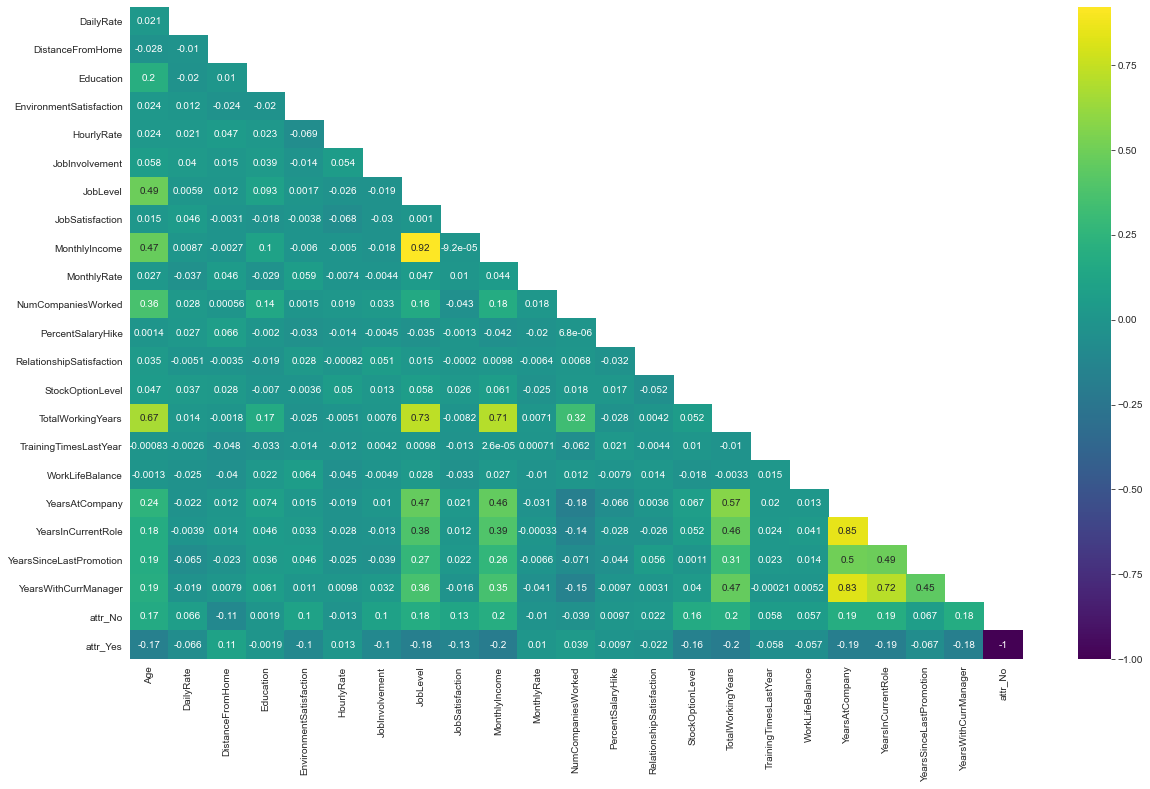

In [54]:
displayCorrelationHeatMap(splitByType(employee_info)['non_object_type'].corr(method='spearman'))

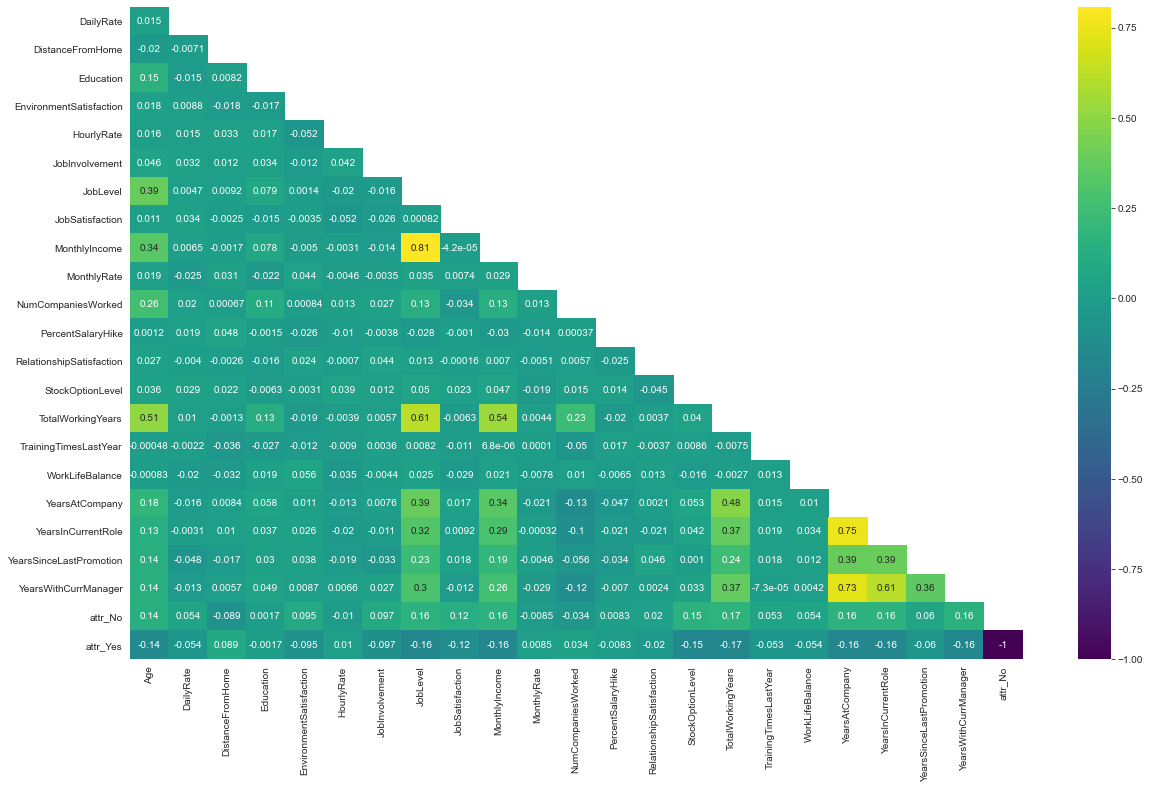

In [55]:
displayCorrelationHeatMap(splitByType(employee_info)['non_object_type'].corr(method='kendall'))

We can see that from both the spearman and kendall implementations, the correlation values are similar but kendall's tau is less optimistic when compared to spearman's rho (smaller values for kendall's tau). This is expected due to the higher sensitivity to deviations and variations of spearman's rho.

Similar to the categorical data results, we can see that some attributes/features/predictors are correlated with each other such as MonthlyIncome and JobLevel, YearsAtCompany and YearsInCurrRole, YearsAtCompany and YearWithCurrManager, etc. These attributes can be combined or dropped depending on the model implemented.

For out target class variable, we can potentially use the following predictors (based on kendall's tau):
 * Age (0.14)
 * JobLevel (0.16)
 * JobSatisfaction (0.12)
 * MonthlyIncome (0.16)
 * StockOptionLevel (0.15)
 * TotalWorkingYears (0.17)
 * YearsAtCompany (0.16)
 * YearsInCurrentRole (0.16)
 * YearsWithCurrManage (0.16)

However, they all display a weak correlation with the attrition target class variable.

Reference:
 * https://www.statisticssolutions.com/kendalls-tau-and-spearmans-rank-correlation-coefficient/

Additionally, we can discretize the non-categorical attributes and re-apply Cramer's V and Theil's U to get a more consist test on all of the features/predictors/variables. But from this exploratory data analysis conducted, we can think about applying binary classifiers like logistic regression, support vector machine, random forest, etc.

## References
 - https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15
 - https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
 - https://stackoverflow.com/questions/20892799/using-pandas-calculate-cram%C3%A9rs-coefficient-matrix
 - https://datascience.stackexchange.com/questions/893/how-to-get-correlation-between-two-categorical-variable-and-a-categorical-variab
 - https://www.spss-tutorials.com/cramers-v-what-and-why/
 - https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
 - https://www.kdnuggets.com/2020/04/data-transformation-standardization-normalization.html
 - https://maxhalford.github.io/blog/target-encoding/
 - https://pbpython.com/categorical-encoding.html
 - https://stackoverflow.com/questions/18689823/pandas-dataframe-replace-nan-values-with-average-of-columns
 - https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c
 - https://towardsdatascience.com/heatmap-basics-with-pythons-seaborn-fb92ea280a6c
 - https://seaborn.pydata.org/generated/seaborn.heatmap.html
 - https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
 - https://www.statisticshowto.com/uncertainty-coefficient/

## END